<a href="https://colab.research.google.com/github/livvyhancock/Stock-pricing-model/blob/main/PricePredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
!pip install feedparser
import feedparser
import json
import requests
!pip install vaderSentiment
!pip install pandas
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import http.client
import matplotlib.pyplot as plt
import datetime
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
#nlp
!pip install transformers
from transformers import pipeline

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 861.9 kB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=eefb6f5ab49f2df0c1e3aaf537781b5f0a40fcdae1f669174c76165dca35ea36
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.4 MB/s eta 0:00:00


#globals

In [ ]:
ticker = 'MKS.L'
query = "marks and spencer"
other_names = ["M&S"] #optional

#1 GET NEWS

In [ ]:
API_KEY = "83df971e-bdd7-440f-9f64-674924bc5dd3"

#query is a global
from_date = "2024-04-21"
to_date = "2025-04-21"

url = (
    f"https://content.guardianapis.com/search"
    f"?q={query}"
    f"&from-date={from_date}&to-date={to_date}"
    f"&page-size=15"
    f"&api-key={API_KEY}"
)

response = requests.get(url)
data = response.json()
print(data)

articles = data['response']['results']

# Loop through each article and extract the headline and timestamp
headlines_and_timestamps = []

for article in articles:
    headline = article['webTitle']
    timestamp = article['webPublicationDate']

    # Store the headline and timestamp in a tuple or dictionary
    headlines_and_timestamps.append({
        'headline': headline,
        'timestamp': timestamp
    })

# Print the collected headlines and timestamps
for item in headlines_and_timestamps:
    print(f"Headline: {item['headline']}")
    print(f"Timestamp: {item['timestamp']}")
    print("-" * 40)


headlines_and_timestamps_df = pd.DataFrame(headlines_and_timestamps)
print(headlines_and_timestamps_df)

{'response': {'status': 'ok', 'userTier': 'developer', 'total': 1308, 'startIndex': 1, 'pageSize': 15, 'currentPage': 1, 'pages': 88, 'orderBy': 'relevance', 'results': [{'id': 'business/article/2024/jun/29/marks-spencer-to-launch-clothing-repair-and-alterations-service', 'type': 'article', 'sectionId': 'business', 'sectionName': 'Business', 'webPublicationDate': '2024-06-29T11:56:47Z', 'webTitle': 'Marks & Spencer to launch clothing repair and alterations service', 'webUrl': 'https://www.theguardian.com/business/article/2024/jun/29/marks-spencer-to-launch-clothing-repair-and-alterations-service', 'apiUrl': 'https://content.guardianapis.com/business/article/2024/jun/29/marks-spencer-to-launch-clothing-repair-and-alterations-service', 'isHosted': False, 'pillarId': 'pillar/news', 'pillarName': 'News'}, {'id': 'business/2024/oct/18/bella-freuds-marks-spencer-collection-sells-out-in-a-day', 'type': 'article', 'sectionId': 'business', 'sectionName': 'Business', 'webPublicationDate': '2024-

#2 sentiment analysis on news, adds column to df with how the sentiment predicted to affect stock prices (NEED TO TRY DIFF MODELS COS MIGHT NOT Agree)



In [ ]:
# Load the classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Your context labels
labels = ["retail company", "grocery store", "fashion brand", "not relevant"]

labels = ["retail company", "grocery store", "fashion brand", "technology", "politics", "sports", "not relevant"]

# Function to classify headline and return context + score
def classify_headline_context(headline):
    result = classifier(headline, labels)
    top_label = result['labels'][0]
    top_score = result['scores'][0]
    return pd.Series([top_label, top_score])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:

# Apply to your DataFrame
headlines_and_timestamps_df[['context_label', 'context_confidence']] = headlines_and_timestamps_df['headline'].apply(classify_headline_context)

# Now you can filter if you want
filtered_df = headlines_and_timestamps_df[headlines_and_timestamps_df['context_label'].isin([
    "retail company", "grocery store", "fashion brand"
])]

print(filtered_df)

                                             headline             timestamp  \
0   Marks & Spencer to launch clothing repair and ...  2024-06-29T11:56:47Z   
1   Most of Bella Freud’s Marks & Spencer collecti...  2024-10-18T13:16:26Z   
5   New Marks & Spencer building will be a showcas...  2024-06-18T17:03:45Z   
6   Marks & Spencer boss hails ‘growth story’ as a...  2024-05-22T11:48:28Z   
8   Waitrose brings back free coffee for shoppers ...  2025-01-22T09:12:53Z   
10  JD Sports cuts profit forecast, blaming big fa...  2025-01-14T09:11:38Z   

     context_label  context_confidence  
0   retail company            0.953570  
1    fashion brand            0.538875  
5   retail company            0.831926  
6   retail company            0.965398  
8   retail company            0.560473  
10  retail company            0.694958  


In [ ]:
# filter the search results by context
import spacy

# Load English NLP model
nlp = spacy.load("en_core_web_sm")

def is_relevant_article(headline, target_entity, keywords=None):
    if keywords is None:
        keywords = []

    # First: Check named entities for the target entity
    doc = nlp(headline)
    for ent in doc.ents:
        if target_entity.lower() in ent.text.lower() and ent.label_ == "ORG":
            return True

    # Second: Keyword-based matching (lowercase comparison)
    headline_lower = headline.lower()
    for kw in keywords:
        if kw.lower() in headline_lower:
            return True

    return False

print(headlines_and_timestamps_df)
# Apply the filter to the 'headline' column
headlines_and_timestamps_df['is_relevant'] = headlines_and_timestamps_df['headline'].apply(
    lambda x: is_relevant_article(x, target_entity=query, keywords=other_names)
)

# Filter the DataFrame for only relevant articles
filtered_df = headlines_and_timestamps_df[headlines_and_timestamps_df['is_relevant'] == True]

print(filtered_df)

                                             headline             timestamp  \
0   Marks & Spencer to launch clothing repair and ...  2024-06-29T11:56:47Z   
1   Most of Bella Freud’s Marks & Spencer collecti...  2024-10-18T13:16:26Z   
2                               June Spencer obituary  2024-11-08T17:39:34Z   
3   Question marks over Europe’s defence splurges ...  2025-03-06T18:18:21Z   
4   Gulf in US and Russian expectations marks star...  2025-03-23T22:07:12Z   
5   New Marks & Spencer building will be a showcas...  2024-06-18T17:03:45Z   
6   Marks & Spencer boss hails ‘growth story’ as a...  2024-05-22T11:48:28Z   
7                             Norman Spencer obituary  2024-09-18T16:19:27Z   
8   Waitrose brings back free coffee for shoppers ...  2025-01-22T09:12:53Z   
9   Tuvalu marks ‘momentous occasion’ with unveili...  2025-04-16T00:10:56Z   
10  JD Sports cuts profit forecast, blaming big fa...  2025-01-14T09:11:38Z   
11  Trump marks 7 October anniversary and criticiz..

try out models by printing healines and the compound score to see if agree

In [ ]:
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()



headline_timestamp_and_sentiment = []
# Collect the headlines, timestamps, and sentiment scores
for item in headlines_and_timestamps:
    headline = item['headline']
    timestamp = item['timestamp']
    sentiment_score = analyzer.polarity_scores(headline)

    # Append each row as a dictionary to the list
    headline_timestamp_and_sentiment.append({
        'headline': headline,
        'timestamp': timestamp,
        'sentiment': sentiment_score['compound']  # Using the 'compound' score for overall sentiment- delete to see neg neu and pos breakdown
    })

# Create a pandas DataFrame (table)
headline_timestamp_and_sentiment_df = pd.DataFrame(headline_timestamp_and_sentiment)
print(headline_timestamp_and_sentiment_df)

                                             headline             timestamp  \
0   Marks & Spencer to launch clothing repair and ...  2024-06-29T11:56:47Z   
1   Most of Bella Freud’s Marks & Spencer collecti...  2024-10-18T13:16:26Z   
2                               June Spencer obituary  2024-11-08T17:39:34Z   
3   Question marks over Europe’s defence splurges ...  2025-03-06T18:18:21Z   
4   Gulf in US and Russian expectations marks star...  2025-03-23T22:07:12Z   
5   New Marks & Spencer building will be a showcas...  2024-06-18T17:03:45Z   
6   Marks & Spencer boss hails ‘growth story’ as a...  2024-05-22T11:48:28Z   
7                             Norman Spencer obituary  2024-09-18T16:19:27Z   
8   Waitrose brings back free coffee for shoppers ...  2025-01-22T09:12:53Z   
9   Tuvalu marks ‘momentous occasion’ with unveili...  2025-04-16T00:10:56Z   
10  JD Sports cuts profit forecast, blaming big fa...  2025-01-14T09:11:38Z   
11  Trump marks 7 October anniversary and criticiz..

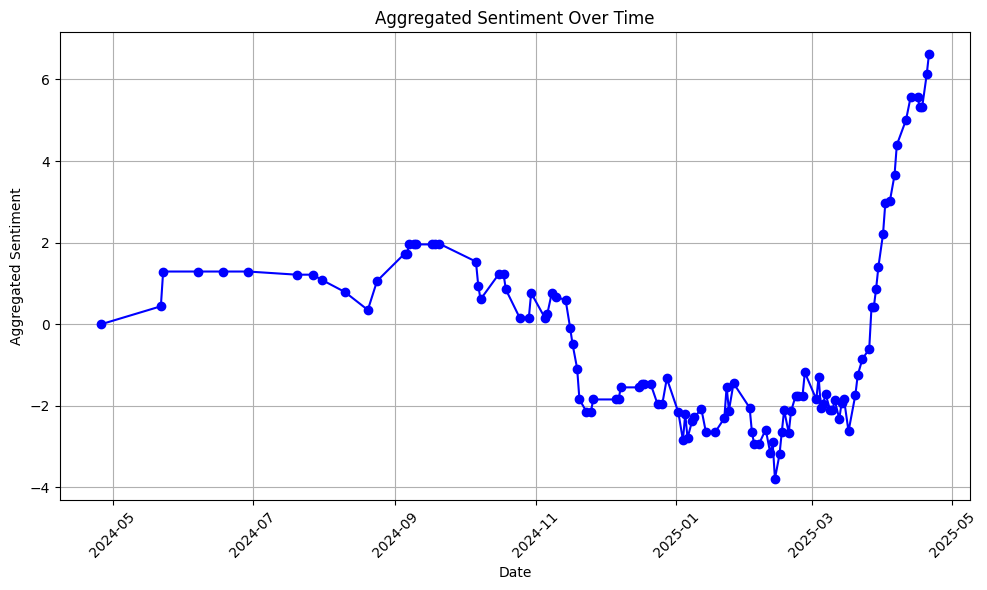

In [ ]:
df = headline_timestamp_and_sentiment_df
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
aggregated_df = df.groupby('date')['sentiment'].sum().reset_index()
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])
aggregated_df['cumulative_sentiment'] = aggregated_df['sentiment'].cumsum()
aggregated_df['cumulative_sentiment'] *= 1
cumulative_sentiment = aggregated_df['cumulative_sentiment']

plt.figure(figsize=(10, 6))
plt.plot(aggregated_df['date'], cumulative_sentiment, marker='o', linestyle='-', color='b', label='sentiment')
plt.xlabel('Date')
plt.ylabel('Aggregated Sentiment')
plt.title('Aggregated Sentiment Over Time')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

# 3 what is the pricing

In [ ]:
conn = http.client.HTTPSConnection("yahoo-finance127.p.rapidapi.com")

headers = {
    'x-rapidapi-key': "065811b66amsh470d8e1664f3edep11044cjsn4934d5b661bd",
    'x-rapidapi-host': "yahoo-finance127.p.rapidapi.com"
}

#ticker is global
conn.request("GET", f"/historic/{ticker}/1d/1y", headers=headers)

res = conn.getresponse()
data = res.read()


parsed = json.loads(data.decode("utf-8"))
print(data.decode("utf-8"))

import pprint
#pprint.pprint(parsed)

{"meta":{"currency":"GBp","symbol":"MKS.L","exchangeName":"LSE","fullExchangeName":"LSE","instrumentType":"EQUITY","firstTradeDate":583743600,"regularMarketTime":1744904243,"hasPrePostMarketData":false,"gmtoffset":3600,"timezone":"BST","exchangeTimezoneName":"Europe/London","regularMarketPrice":411.3,"fiftyTwoWeekHigh":415.299,"fiftyTwoWeekLow":251.4,"regularMarketDayHigh":412.3,"regularMarketDayLow":395.6,"regularMarketVolume":6830639,"longName":"Marks and Spencer Group plc","shortName":"MARKS AND SPENCER GROUP PLC ORD","chartPreviousClose":248.1,"priceHint":2,"currentTradingPeriod":{"pre":{"timezone":"BST","start":1744870500,"end":1744873200,"gmtoffset":3600},"regular":{"timezone":"BST","start":1744873200,"end":1744903800,"gmtoffset":3600},"post":{"timezone":"BST","start":1744903800,"end":1744906500,"gmtoffset":3600}},"dataGranularity":"1d","range":"1y","validRanges":["1d","5d","1mo","3mo","6mo","1y","2y","5y","10y","ytd","max"]},"timestamp":[1713337200,1713423600,1713510000,17137692

          date  cumulative_sentiment  scaled_cumulative_sentiment
0   2024-04-26                0.0000                   305.953805
1   2024-05-22                0.4404                   312.948506
2   2024-05-23                1.2923                   326.478903
3   2024-06-07                1.2923                   326.478903
4   2024-06-18                1.2923                   326.478903
..         ...                   ...                          ...
108 2025-04-16                5.5648                   394.337359
109 2025-04-17                5.3148                   390.366706
110 2025-04-18                5.3148                   390.366706
111 2025-04-20                6.1222                   403.190327
112 2025-04-21                6.6328                   411.299988

[113 rows x 3 columns]


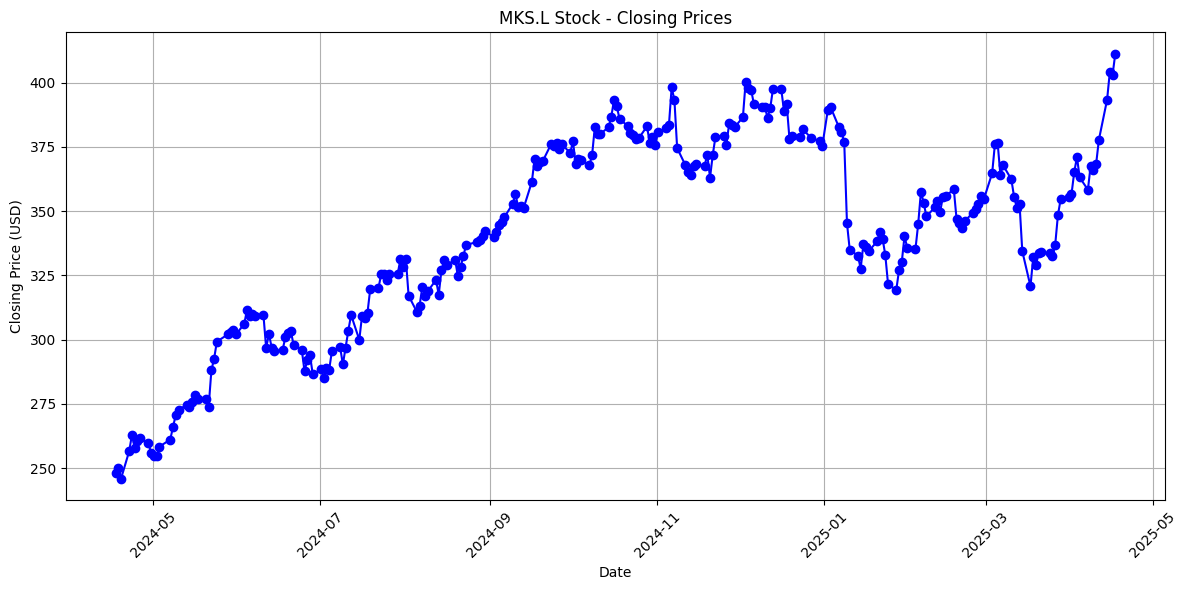

In [ ]:


# Extract and convert
timestamps = parsed["timestamp"]
closing_prices = parsed["indicators"]["quote"][0]["close"]
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]


#scale the sentiment dataset to the closing prices to plot on same graph
filtered_prices = [price for price in closing_prices if price is not None]
new_min = np.min(filtered_prices)
new_max = np.max(filtered_prices)
scaler = MinMaxScaler(feature_range=(new_min, new_max)) # Initialize MinMaxScaler with the desired range
scaled_sentiment = scaler.fit_transform(aggregated_df[['cumulative_sentiment']])  # Reshape the cumulative_sentiment column to 2D array for scaling
aggregated_df['scaled_cumulative_sentiment'] = scaled_sentiment # Add the scaled values as a new column
print(aggregated_df[['date', 'cumulative_sentiment', 'scaled_cumulative_sentiment']]) # If you want to see the updated DataFrame with the scaled cumulative sentiment column

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, closing_prices, marker='o', linestyle='-', color='blue')
plt.title(f"{ticker} Stock - Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#longterm comparison plot

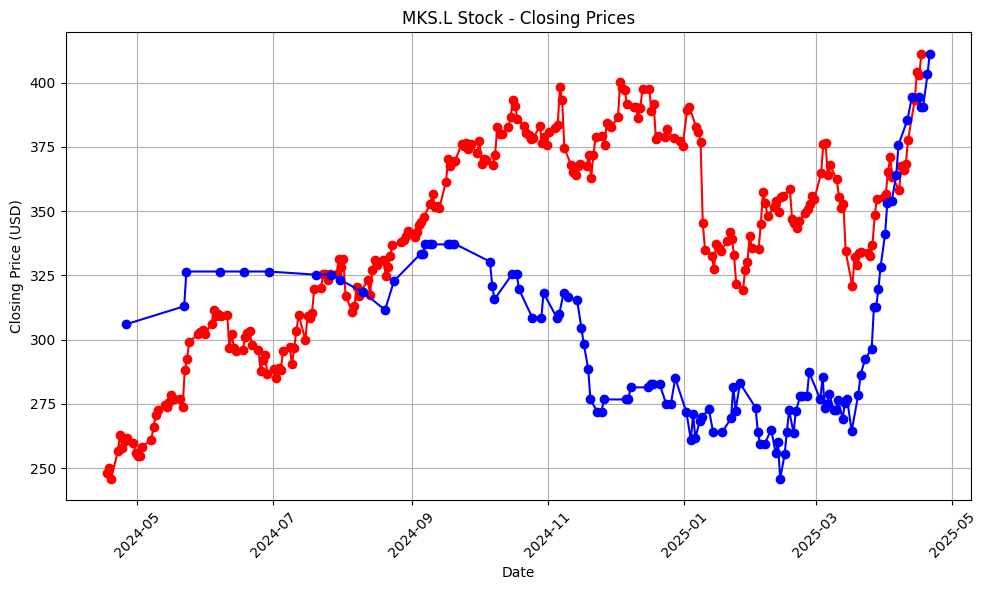

In [ ]:


plt.figure(figsize=(10, 6))

plt.plot(dates, closing_prices, marker='o', linestyle='-', color='red')
plt.plot(aggregated_df['date'], scaled_sentiment, marker='o', linestyle='-', color='b', label='Aggregated Sentiment')
plt.title(f"{ticker} Stock - Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()



#daily comp for whether the cumulative sentiment for the previous week predicts the stock change